<a href="https://colab.research.google.com/github/gutzeitJ/Projects/blob/master/TeAP2025tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TeAP 2025 Tutorial: training neural networks on psychological tasks
## Giacomo Aldegheri

In this tutorial, we are going to implement a (highly simplified!) version of a [paper](https://www.nature.com/articles/s41593-024-01607-5) by Riverland & Pouget (2024). In this paper, the authors show that neural networks that receive as input a stimulus and instructions specifying the task are able to successfully learn multiple tasks, and even generalize to new ones!

First, let's understand what they did at a high level:
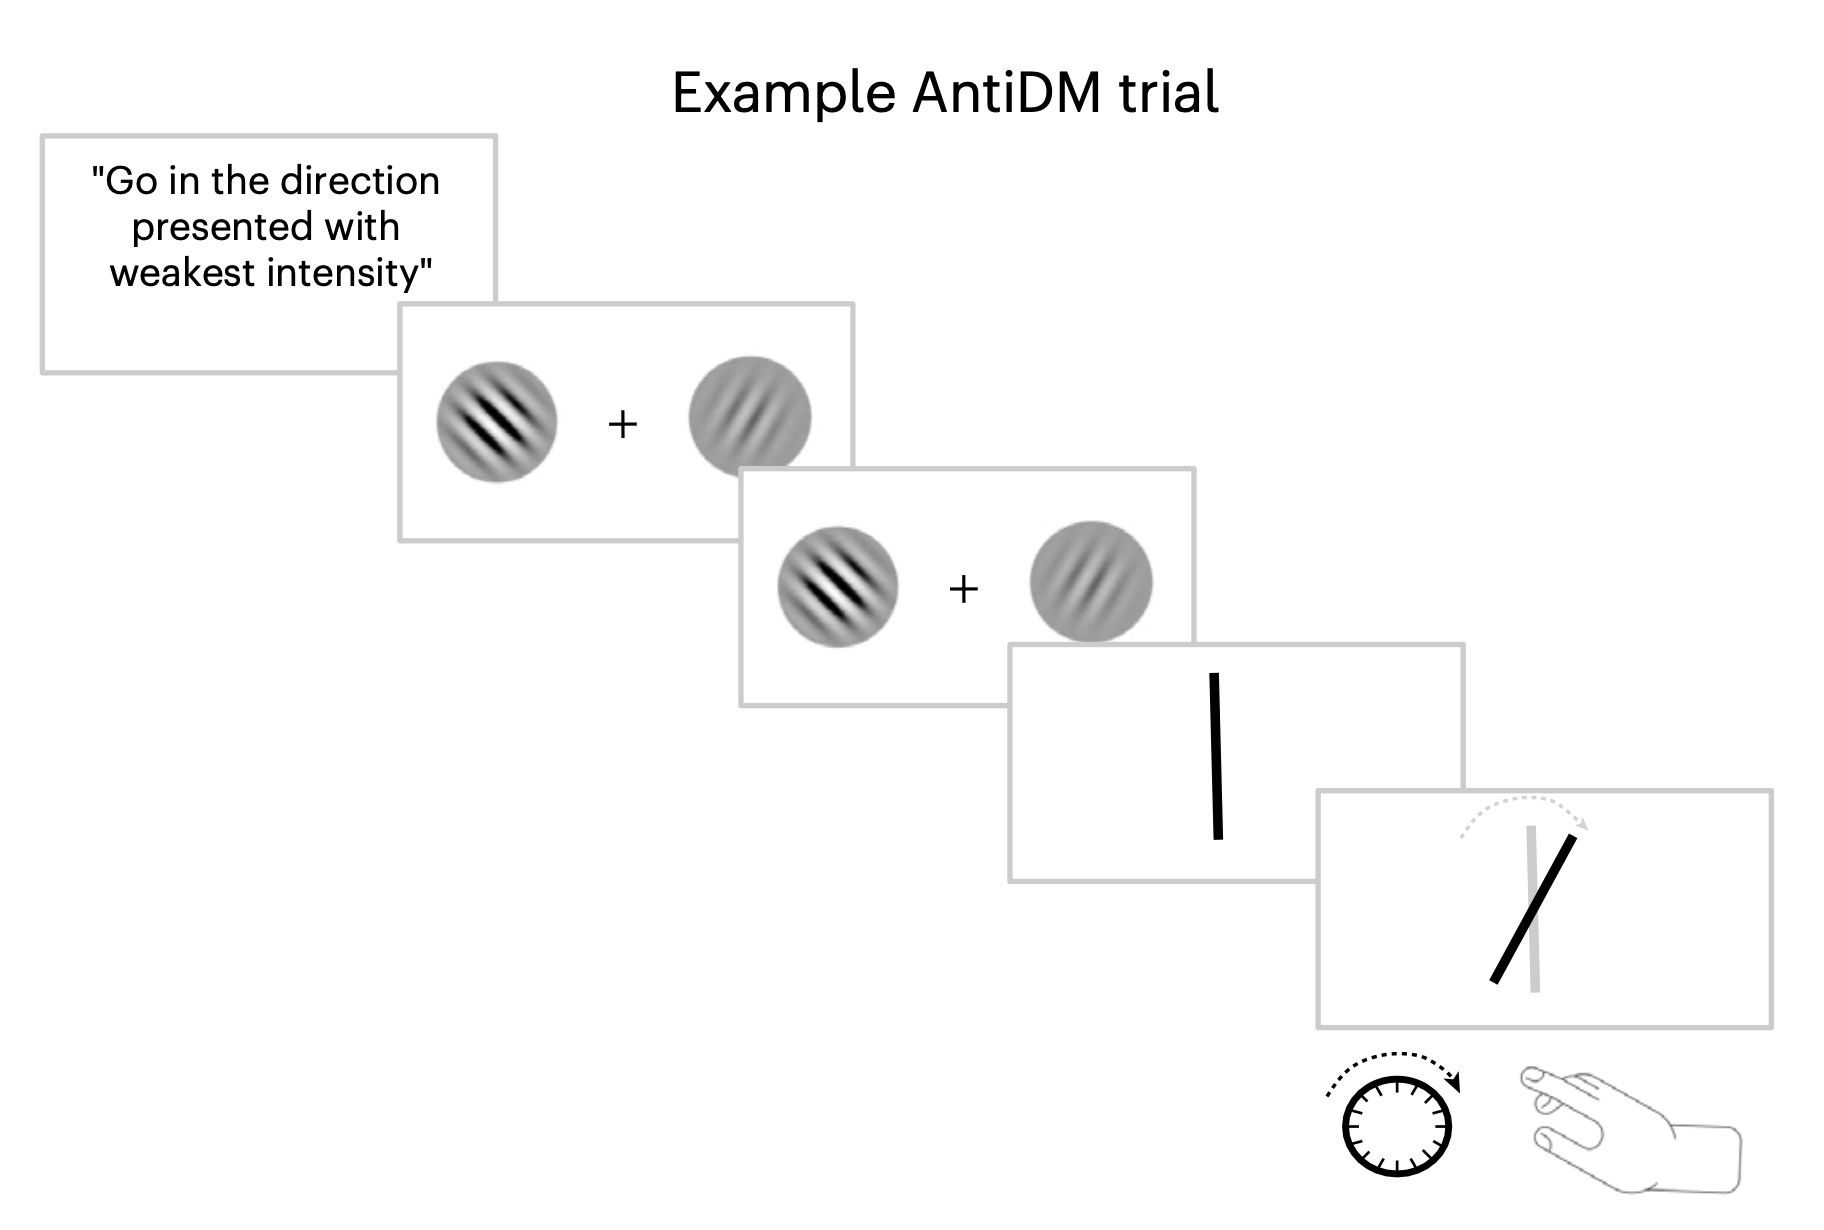

The network's task is, given two stimuli (with different orientations and intensities), to give a continuous response (an orientation) based on the instructions. The instructions keep changing from trial to trial, so the network needs to respond differently to similar stimuli.




As the first step, let's import all the packages we will need for this tutorial!

In [ ]:
# @title Import necessary packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from scipy.stats import ortho_group
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Literal, Iterable
from collections import UserDict
from copy import deepcopy
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
import pdb

Now, let's code some visualization functions to see what the stimuli look like! (feel free to take a look at the code to see how it works)

In [ ]:
# @title Visualization Utilities
def generate_gabor(theta=0.0,
                   contrast=1.0,
                   size=128,
                   frequency=0.05,
                   sigma=0.15,
                   phase=0.0):
  """
  Generate a single Gabor patch as a 2D numpy array.

  Parameters
  ----------
  orientation : float
      Orientation of the Gabor in radians (0 = vertical).
  contrast : float
      Contrast of the Gabor, between 0 and 1.
  size : int
      Size in pixels (the output array will be size x size).
  frequency : float
      Spatial frequency (cycles per pixel). Adjust to get desired stripes.
  sigma : float
      Standard deviation of the Gaussian envelope, relative to size (0 < sigma <= 0.5).
      The actual sigma in pixels = sigma * size.
  phase : float
      Phase offset of the Gabor in radians.

  Returns
  -------
  gabor : 2D numpy array, shape = (size, size), values in [0, 1].
  """

  # Create x, y coordinates with 0, 0 in the center
  # range [-1, 1] so that the largest dimension is 2 in each direction
  coords = np.linspace(-1, 1, size)
  x, y = np.meshgrid(coords, coords)

  # Rotate x, y by orientation
  x_rot = x * np.cos(theta) + y * np.sin(theta)
  y_rot = -x * np.sin(theta) + y * np.cos(theta)

  # Gaussian envelope
  gauss = np.exp(-(x**2 + y**2) / (2 * sigma**2))

  # Grating
  grating = np.cos(2 * np.pi * frequency * x_rot + phase)

  # Combine Gaussian and grating, scale to 0.5 ± 0.5*contrast
  gabor = 0.5 + 0.5 * contrast * gauss * grating

  # Clip to [0,1] just in case
  gabor = np.clip(gabor, 0, 1)

  return gabor


def draw_gabors(orientation: tuple =(None, None),
                contrast: tuple =(None, None),
                size: int=128,
                frequency: float = 0.05,
                sigma: float = 0.15,
                phase: float = 0.0,
                bg_level: float = 0.5,
                separation: int = 50,
                figsize: tuple = (6,3)):
    """
    Create a gray background, embed up to two Gabor patches
    (left and/or right), and display the result.

    If orientation_left/contrast_left is None, the left patch is skipped.
    If orientation_right/contrast_right is None, the right patch is skipped.

    Parameters
    ----------
    orientation: tuple
        Orientation for left/right Gabor in degrees. If None, skip that Gabor.
    contrast: tuple
        Contrast for left/right Gabor. If None, skip that Gabor.
    size : int
        Size of each Gabor patch in pixels (square).
    frequency : float
        Spatial frequency for Gabors (cycles per pixel).
    sigma : float
        Standard deviation of the Gaussian envelope for Gabors.
    phase : float
        Phase offset for the Gabors.
    bg_level : float
        Background level in range [0,1].
    separation : int
        Horizontal separation (in pixels) between the centers of the two Gabors.
    figsize : tuple
        Size of the figure in inches for plotting.

    Returns
    -------
    display : 2D or 3D numpy array
        The final grayscale image containing the background and the Gabor(s).
        Values in [0,1]. Shape = (size, 2*(size + separation), 3) if color.
        Or (height, width) if you prefer single-channel grayscale.
    """

    width = 2 * size + separation
    height = size

    orientation_left, orientation_right = orientation
    contrast_left, contrast_right = contrast

    # Create background image (grayscale 2D array)
    display = np.ones((height, width)) * bg_level

    if orientation_left is not None and contrast_left is not None:
      gabor_left = generate_gabor(theta=orientation_left,
                                  contrast=contrast_left,
                                  size=size,
                                  frequency=frequency,
                                  sigma=sigma,
                                  phase=phase)
      display[:size, :size] = gabor_left

    if orientation_right is not None and contrast_right is not None:
      gabor_right = generate_gabor(theta=orientation_right,
                                  contrast=contrast_right,
                                  size=size,
                                  frequency=frequency,
                                  sigma=sigma,
                                  phase=phase)
      display[:size, size+separation:] = gabor_right

    # Convert to RGB for plotting
    # (If you want a pure grayscale output, you can skip this.)
    display_rgb = np.dstack([display, display, display])

    # Show the image
    plt.figure(figsize=figsize)
    plt.imshow(display_rgb, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

Given two orientations and two contrast levels, the `draw_gabors` function draws the stimuli as Gabor patches.



In [ ]:
draw_gabors(
        orientation=(0, 1.2*np.pi), contrast= (1.0, 0.2),
        size=128, frequency=3., sigma=0.3, phase=0.0,
        bg_level=0.5, separation=20, figsize=(6,3)
    )

## Stimulus encoding

Now, let's understand how the encoding of the stimuli is implemented! The orientations are represented as 'bumps' of activity in a population of orientation-selective cells, similar to simple cells in primary visual cortex (V1):

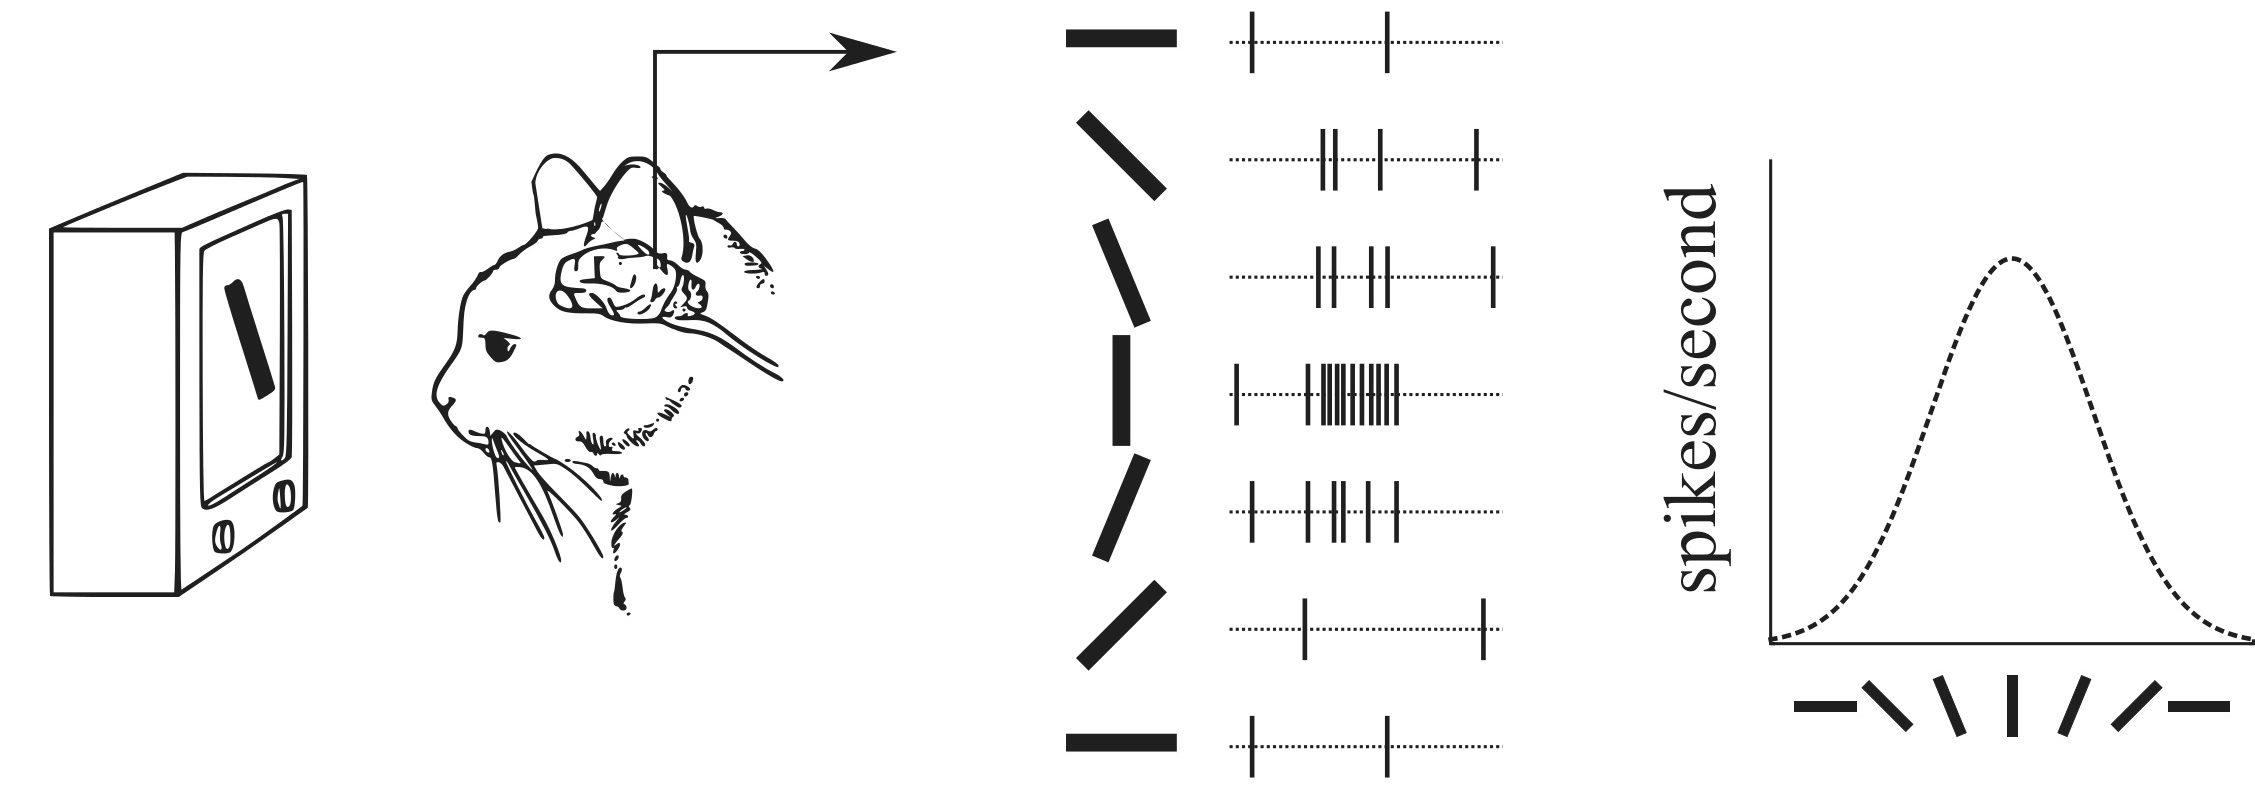

We specify the number of 'cells' we want (32, in our case) and each of these is tuned to an orientation between $0$ and $2\pi$: it responds maximally to that orientation, a bit less to very similar orientations, a bit less still to less similar orientations, etc. with a Gaussian tuning profile.

In [ ]:
# Coding of inputs
STIM_DIM = 32
TUNING_DIRS = [((2*np.pi*i)/STIM_DIM) for i in range(STIM_DIM)]

We implement a `PopulationVectorTransform` which turns stimulus parameters (orientation and intensity) into a population vector representation. The intensity is multiplied with the stimulus to amplify it or reduce it. After we have created our population response, we add some Gaussian noise to it.

In [ ]:
class PopulationVectorTransform:
  def __init__(self, noise=0.0, to_tensor=True, label=False):
    self.noise = noise
    self.to_tensor = to_tensor
    self.label = label

  def __call__(self, trial_params):
    if not self.label:
      popvector = self._make_stimulus_pair(trial_params)
    else:
      popvector = self._make_label(trial_params)

    if self.noise and not self.label:
      popvector = self._add_noise(popvector)

    if self.to_tensor:
      popvector = torch.tensor(popvector, dtype=torch.float)

    return popvector

  def _make_stimulus_pair(self, trial_params):
    left_stim = self._make_activity_vectors(trial_params['orient_left'].to_numpy(),
                                            trial_params['int_left'].to_numpy())
    right_stim = self._make_activity_vectors(trial_params['orient_right'].to_numpy(),
                                             trial_params['int_right'].to_numpy())
    stimulus = np.hstack([left_stim, right_stim])

    return stimulus

  def _make_label(self, trial_params):
    label = self._make_activity_vectors(trial_params['corr_orient'].to_numpy())

    return label

  def _make_activity_vectors(self, orients, contrasts=None):
    """
    Constructs array representing hills of activity across orientations.
    Parameters:
      - orient, contrast: stimulus orientations (0-2pi) and intensity
    Returns:
      - rolled[1, STIM_DIM]: array containing bump of activity, scaled by
          the stimulus intensity
    """
    if contrasts is None:
      contrasts = np.ones_like(orients)
    assert len(orients) == len(contrasts)
    contrasts[np.isnan(orients)] = 0
    num_trials = len(orients)
    centered_dir = np.repeat(np.array([[0.8 * np.exp(-0.5 * (((12*np.abs(np.pi-i))/np.pi)**2)) for i in TUNING_DIRS]]), num_trials, axis=0)
    roll = np.nan_to_num(np.floor((orients/(2*np.pi))*STIM_DIM)-np.floor(STIM_DIM/2)).astype(int)
    rolled = np.array(list(map(np.roll, centered_dir, roll)))
    rolled = rolled[range(num_trials), ...] * contrasts[:, None][range(num_trials)]

    return rolled

  def _add_noise(self, array):

    if isinstance(self.noise, tuple):
      varying_noise = np.random.uniform(low=self.noise[0],
                                        high=self.noise[1],
                                        size=len(array))
      noise_arr = np.empty_like(array)
      for i, sd in enumerate(varying_noise):
        noise_arr[i, ...] = sd * np.random.normal(size=array.shape[1:])
    else:
      # noise is a constant scalar
      noise_arr = self.noise * np.random.normal(size=array.shape)

    return array + noise_arr

In [ ]:
# @title Visualize the population vector for a few example trials
popvector = PopulationVectorTransform(noise=(0.01, 0.2), to_tensor=False)
orientations_left = [0., np.pi/2, np.pi/3, np.pi]
orientations_right = [1., np.pi*0.75, np.pi, 0.]
intensities_left = [0.8, 0.9, 1.1, 1.0]
intensities_right = [0.95, 1.05, 0.87, 0.8]
example_df = pd.DataFrame({
    'orient_left': orientations_left,
    'orient_right': orientations_right,
    'int_left': intensities_left,
    'int_right': intensities_right
})
activations = popvector(example_df)
plt.matshow(np.repeat(activations, 5, axis=0)[:25, :])
plt.axvline(x=31.5, color='r', linestyle='-')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Instructions embedding

Great! Now, let's turn to the representation of the instructions.

As with everything concerning neural networks, we need to convert the instructions in a _distributed_ representation to be able to feed them to a neural network. Basically, we need to turn them into continuous vectors, the same way that we did with our stimulus orientations above.

But how can we turn linguistic data, which is discrete and symbolic by definition, into continuous representations? Fortunately, **language models** come to our rescue!

In recent years, a lot of progress has been made in developing models that take sentences as input, and generate an _embedding_ vector, which summarizes the semantic and syntactic properties of those sentences.

<img src="https://huggingface.co/blog/assets/95_training_st_models/training_process.png">

A lot of these models can be very easily obtained from [Hugging Face](https://huggingface.co/sentence-transformers). With a single line of code, we can have our embeddings! That's what we will use now.

In [ ]:
embedder = SentenceTransformer("all-mpnet-base-v2")
embedding = embedder.encode('Hey, how are you', convert_to_tensor=False)

We can take a look at our embedding - it's a 768-dimensional vector encoding the meaning of the sentence:

In [ ]:
embedding

We wrap the language embedding into another `Transform`for encoding our instructions:

In [ ]:
class InstructionEmbedTransform:
  def __init__(self, to_tensor=True):
    self.embedder = SentenceTransformer("all-mpnet-base-v2")
    self.to_tensor = to_tensor

  def __call__(self, trial_params):
    embedding = self.embedder.encode(trial_params['instructions'].tolist(),
                                     convert_to_tensor=self.to_tensor,
                                     show_progress_bar=True)
    return embedding.cpu()

class ConcatenateTransforms:
  def __init__(self, transforms_list):
    self.transforms_list = transforms_list

  def __call__(self, trial_params):
    outputs = [t(trial_params) for t in self.transforms_list]
    return torch.cat(outputs, dim=-1)

# Task Specifications

This is actually the most involved part of this tutorial, just like it's often the most involved part of designing a psychological experiment. We need to provide instructions for each task, and define all the trial parameters according to the task.

In [ ]:
TRAIN_INSTRUCT_DICT = {}
TRAIN_INSTRUCT_DICT['Go'] = ('respond in the direction of the stimulus',
                             'respond with the same direction as the displayed orientation',
                             'choose the orientation displayed',
                             'go in the presented direction',
                             'select the displayed orientation',
                             'pick the displayed orientation',
                             'reproduce the orientation you see',
                             'choose the orientation of the stimulus',
                             'respond with the shown orientation',
                             'reproduce the shown direction',
                             'respond with the same orientation as the presented stimulus',
                             'go in the orientation indicated by the stimulus',
                             'go in the direction presented on the display',
                             'choose the displayed orientation',
                             'your response should be the orientation shown in the stimulus')

TRAIN_INSTRUCT_DICT['OppositeGo'] = ('respond with the opposite of the shown orientation',
                                     'respond in the reverse direction from the one you see',
                                     'choose the opposite of the displayed direction',
                                     'choose the opposite direction',
                                     'respond with the reverse orientation',
                                     'go in reverse of the displayed orientation',
                                     'your response should be the opposite of that shown in the stimulus',
                                     'go in the opposite direction from the stimulus',
                                     'choose the reverse of the stimulus orientation',
                                     'pick the opposite orientation of the displayed stimulus',
                                     'your response should be the reverse of the presented stimulus',
                                     'opt for the opposite of the presented direction',
                                     'go in the opposite direction',
                                     'respond with the reverse of the stimulus direction',
                                     'opt for the reverse of the orientation shown')

TRAIN_INSTRUCT_DICT['DM'] = ('respond in the direction of the stimulus with the higher intensity',
                             'choose the more intense stimulus',
                             'go in the direction of the stimulus with greater strength',
                             'respond to the strongest stimulus',
                             'pick the more intensely displayed stimulus',
                             'choose the stimulus which has the highest intensity',
                             'reproduce the orientation of the more intense stimulus',
                             'choose the orientation with greater strength',
                             'go in the more intensely displayed direction',
                             'pick the orientation shown more strongly',
                             'choose the direction of the stimulus with maximal strength',
                             'respond in the direction of the strongest stimulus',
                             'reproduce the stronger orientation',
                             'go in the direction of the stimulus displayed with more intensity',
                             'reproduce the stronger stimulus orientation')

TRAIN_INSTRUCT_DICT['AntiDM'] = ('respond in the direction of the stimulus with the lower intensity',
                                 'choose the less intense stimulus',
                                 'go in the direction of the stimulus with lesser strength',
                                 'respond to the weakest stimulus',
                                 'pick the less intensely displayed stimulus',
                                 'choose the stimulus which has the lowest intensity',
                                 'reproduce the weaker orientation',
                                 'go in the direction of the weaker stimulus',
                                 'pick the orientation presented with less intensity',
                                 'reproduce the orientation displayed with less strength',
                                 'select the stimulus which has the lowest strength',
                                 'pick the weakest direction',
                                 'reproduce the orientation with minimal intensity',
                                 'go in the weaker direction',
                                 'respond to the less intense stimulus')

TRAIN_INSTRUCT_DICT['CompL'] = ('if the first stimulus is greater than the second stimulus respond to the first stimulus otherwise do not respond',
                                'if the left stimulus has higher intensity than the right go in the left direction otherwise do not respond',
                                'go in the direction of the first stimulus if it is stronger than the second stimulus otherwise do not respond',
                                'when the left stimulus has higher value than the right stimulus respond in the initial direction otherwise do not respond',
                                'only respond to the left stimulus when it has higher intensity than the right, otherwise do not respond',
                                'if the first stimulus is more intense than the second stimulus choose the first direction otherwise do not respond',
                                'do not respond unless the first stimulus is more intense than the second, in which case choose the first orientation',
                                'if the intensity of the left stimulus is higher reproduce its orientation otherwise do not give any response',
                                'reproduce the higher intensity stimulus only if it is on the left otherwise do not respond',
                                'if the stimulus on the left has higher strength than the one on the right go in the left direction otherwise do not respond',
                                'respond with the left orientation if it is shown more intensely than the right otherwise no response',
                                'pick the orientation shown on the left if its strength is greater than the right otherwise do not give a response',
                                'if the left stimulus is stronger reprouce its orientation otherwise do not respond',
                                'only if the left stimulus has higher intensity go in its direction otherwise do not respond',
                                'if left is more intense than right respond with left orientation otherwise do not respond')

TRAIN_INSTRUCT_DICT['CompR'] = ('if the second stimulus is greater than the first respond to the second stimulus otherwise do not respond',
                                'if the right stimulus is stronger than the left respond to the right stimulus otherwise do not give any response',
                                'go in the direction of the right stimulus if it has higher intensity than the left otherwise avoid responding',
                                'if the second stimulus has higher value than the first choose the second orientation otherwise do not respond',
                                'pick the second stimulus if it has higher intensity than the first otherwise do not respond',
                                'choose the right stimulus if it is the more intense one otherwise do not respond',
                                'if the right stimulus is more intense go in its direction otherwise do not give a response',
                                'reproduce the orientation of the right stimulus only if the stronger one otherwise do not respond',
                                'go in the right stimulus orientation if it is displayed more intensely otherwise do not give any response',
                                'pick the second stimulus direction if it is stronger than the second otherwise do not pick any direction',
                                'when the right stimulus is the strongest pick its direction otherwise omit your response',
                                'if the right stimulus is more intense than the left reproduce its orientation otherwise do not respond',
                                'only when the right stimulus has higher intensity pick its orientation otherwise do not respond',
                                'if the right stimulus is the strongest one reproduce its direction else do not respond',
                                'if right is stronger than left pick right, else do not respond')

TRAIN_INSTRUCT_DICT['AntiCompL'] = ('respond in the direction of the left stimulus if it is weaker than the right otherwise do not respond',
                                    'when the left stimulus is less intense than the right respond in its direction otherwise do not respond',
                                    'if the left stimulus has lower intensity than the right respond in its direction otherwise do not respond',
                                    'choose the first stimulus orientation if it is displayed less strongly than the second otherwise do not respond',
                                    'go in the direction of the left stimulus if is shown less intensely than the right otherwise do not respond',
                                    'if the left stimulus is less strong than the right choose the left orientation otherwise do not respond',
                                    'if the left stimulus is the least intense pick its orientation otherwise do not give a response',
                                    'if the leftmost stimulus is weakest reproduce its direction otherwise do nothing',
                                    'only when the left stimulus is less intense respond with its orientation otherwise do not respond',
                                    'respond with the first stimulus orientation if it is the weaker stimulus otherwise do not give any response',
                                    'pick the left stimulus direction if it is the least intense otherwise no response',
                                    'if left is less strong than right pick left otherwise do not respond',
                                    'only pick left when it is less intense else do not give any response',
                                    'do not respond unless the left stimulus is less intense in which case reproduce its direction',
                                    'do not pick any orientation unless the first stimulus is weaker than the second in which case respond with its orientation')

TRAIN_INSTRUCT_DICT['AntiCompR'] = ('when the right stimulus is weaker than the left respond with the right orientation otherwise do not respond',
                                    'choose the orientation of the right stimulus only if that stimulus has less strength than the left otherwise do not respond',
                                    'if the right stimulus is less visible than the left respond to the right orientation otherwise do not respond',
                                    'respond with the orientation of the right stimulus if it is presented with lower intensity than the left otherwise do not respond',
                                    'if the intensity of the right stimulus is lower than the left respond to the right stimulus otherwise do not respond',
                                    'go in the direction of the right stimulus if it is less intense than the left otherwise do not respond',
                                    'if the right stimulus is less intense then pick the right orientation otherwise do nothing',
                                    'only respond with the right orientation when the right stimulus is weaker otherwise do not respond',
                                    'reproduce the right orientation if it is less visible than the left otherwise do not give a response',
                                    'go in the direction of the right stimulus if its intensity is lower than the left otherwise do not respond',
                                    'pick the direction of the second stimulus if it is less intense than the first otherwise do not respond',
                                    'pick the right stimulus direction if it weaker than the left otherwise do not respond',
                                    'respond with the right orientation if it the least intensely displayed otherwise give no response',
                                    'only pick right when it is less intense else do not respond',
                                    'reproduce the orientationn of the right stimulus when it is weaker than the left otherwise do not respond')

TRAIN_INSTRUCT_DICT['OppositeCompL'] = ('if the left stimulus is more intense than the right respond with the opposite of its orientation otherwise do not respond',
                                        'respond with the opposite of the left orientation if it is more intense than the right otherwise do not respond',
                                        'go in the opposite direction from the first stimulus if it is more intense than the second otherwise do not respond',
                                        'if the first stimulus has higher value than the second go in the opposite of its direction otherwise do not respond',
                                        'choose the opposite of the left stimulus if it is presented with higher intensiry than the right otherwise do not respond',
                                        'when the first stimulus is presented with greater strength than the second respond to the first direction otherwise do not respond',
                                        'when the left stimulus is stronger than the right go in the direction opposite to it otherwise do not respond',
                                        'only respond when the left stimulus is more intense than the right, in which case go in the opposite of the left direction',
                                        'pick the reverse orientation of the left stimulus when it is displayed more strongly than the right otherwise do not give a response',
                                        'only when the left stimulus is stronger go in the direction opposite to it otherwise do nothing',
                                        'when the left stimulus is more intense than the right go in the opposite of its orientation otherwise do not respond',
                                        'if the stimulus shown on the left is the strongest one choose the opposite of its orientation else do not respond',
                                        'go in the inverse orientation of the left stimulus when it is displayed more intensely than the right otherwise avoid responding',
                                        'reproduce the orientation opposite to the leftmost stimulus when that stimulus is stronger than the rightmost stimulus otherwise do not respond',
                                        'if the first stimulus is more intense than the second, go in the opposite of the first stimulus orientation otherwise do nothing')

TRAIN_INSTRUCT_DICT['OppositeCompR'] = ('if the right stimulus has greater intensity than the left respond with the opposite of its direction otherwise do not respond',
                                        'respond with the opposite of the direction of the second stimulus only if it is more intense than the first otherwise do not respond',
                                        'choose the opposite direction from the right stimulus if it has higher intensity than the left otherwise do not respond',
                                        'if the right stimulus is stronger than the left respond with the opposite of its direction otherwise do not respond',
                                        'choose the opposite of the right stimulus orientation if the right is more intense than the left otherwise do not respond',
                                        'if the right is more intense than the left respond in the direction of the right otherwise do not respond',
                                        'pick the opposite of the right orientation when the right stimulus is stronger otherwise do not respond',
                                        'when the right stimulus has greater intensity than the left pick the reverse of its orientation otherwise do not give any response',
                                        'avoid giving a response unless the right stimulus is stronger than the left, in which case go in its opposite direction',
                                        'go in the opposite direction from the right stimulus is it is more intense than the left otherwise do not respond',
                                        'reproduce the inverse of the second stimulus orientation if it is stronger than the first otherwise give no response',
                                        'if the intensity of the second stimulus is higher go in the direction opposite to it otherwise do not respond',
                                        'only go in the opposite direction from the right stimulus when that stimulus is more intense otherwise do not give any response',
                                        'when the second stimulus is displayed more intensely than the first go in the direction opposite to the second stimulus otherwise do not respond',
                                        'if the second orientation is the stronger one go in the direction opposite to it otherwise avoid responding')

TRAIN_INSTRUCT_DICT['DMS'] = ('if the first and the second stimuli match then respond with their orientation otherwise do not respond',
                              'if the left and right stimuli have the same orientation then respond with that orientation otherwise do not respond',
                              'respond with the orientation of the stimuli if they have the same orientation otherwise do not respond',
                              'pick the stimuli direction if the left and right direction are identical otherwise do not respond',
                              'respond in the displayed direction if the first and second stimuli match otherwise do not respond',
                              'only if the first and second stimuli have the same orientation respond with their direction otherwise do not respond',
                              'when the orientations of the two stimuli are equal go in their direction otherwise do nothing',
                              'respond with the orientation of the stimuli if they have the same orientation otherwise avoid giving a response',
                              'when the first and second stimuli are oriented equally respond with their common direction otherwise do not respond',
                              'if left and right have the same orientation reproduce that orientation otherwise do not do anything',
                              'if the orientation of the left and right stimuli is the same go in that direction otherwise do not respond',
                              'when there is a match between the left and right orientations reproduce that orientation otherwise give no response',
                              'when the left and right stimulus match choose their orientation otherwise do not respond',
                              'if the orientation of the left is the same as the orientation of the right pick that orientation otherwise do nothing',
                              'if left and right are oriented in the same way respond with their orientation else do not respond')

TRAIN_INSTRUCT_DICT['DNMS'] = ('if the left and right stimuli have different orientations then respond to the right stimulus otherwise do not respond',
                               'respond to the right stimulus if it is oriented differently from the left otherwise do not respond',
                               'if the two stimuli have different orientations respond with the orientation of the right stimulus otherwise do not respond',
                               'select the second orientation if the presented orientations are distinct otherwise do not respond',
                               'choose the right orientation if both presented orientations are mismatched otherwise do not respond',
                               'go in the second direction when stimuli orientations are different otherwise do not respond',
                               'if left and right are oriented differently respond with the right orientation otherwise do nothing',
                               'only respond when the left and right orientations differ, in which case pick the right orientation',
                                'when first orientation is different from second orientation pick the second orientation otherwise do not give a response',
                                'if the left stimulus orientation is not equal to the right respond with the right orientation else do not respond',
                                'reproduce the right orientation when it is different from the left otherwise do not choose any orientation',
                                'pick the second orientation when the first and second orientations are different otherwise do not give any response',
                                'go in the direction of the right stimulus when the two stimuli orientations differ otherwise do nothing',
                                'pick the right orientation if it differs from the left else do not pick anything',
                                'reproduce the right orientation but only when the left and right orientations are not equal otherwise do not respond')

TEST_INSTRUCT_DICT = {}
TEST_INSTRUCT_DICT['Go'] = ('reproduce the stimulus orientation',
                            'go in the direction of the stimulus',
                            'choose the shown direction')
TEST_INSTRUCT_DICT['OppositeGo'] = ('choose the reverse of the shown orientation',
                                    'respond with the opposite direction',
                                    'pick the reverse of the stimulus orientation')

In [ ]:
# @title The task implementations
class TaskFactory:
  def __init__(self, num_trials, training=True):
    self.num_trials = num_trials
    self.instruct_dict = TRAIN_INSTRUCT_DICT if training else TEST_INSTRUCT_DICT
    self.task = None

  def _get_instructions(self):
    instructions = np.random.choice(self.instruct_dict[self.task],
                                    size=self.num_trials)
    return instructions

  def _make_task_dataframe(self, orients_left, orients_right,
                           ints_left, ints_right,
                           corr_resps, corr_orients):
    task_df = pd.DataFrame({'orient_left': orients_left,
                            'orient_right': orients_right,
                            'int_left': ints_left,
                            'int_right': ints_right,
                            'corr_resp': corr_resps,
                            'corr_orient': corr_orients})
    task_df['task'] = self.task
    task_df['instructions'] = self._get_instructions()
    return task_df

  def _get_corr_orients(self, orients_left, orients_right, corr_resps, opposite=False):
    # corr_resps: iterable containing which stimulus should be selected (0/1)
    corr_orients = np.array([orients_left[i] if corr_resps[i] == 0 else orients_right[i] for i in range(self.num_trials)])
    corr_orients[np.isnan(corr_resps)] = np.nan
    if opposite:
      corr_orients = self._get_opposite_orients(corr_orients)
    return corr_orients

  def _random_orients(self):
    orients = np.random.uniform(low=0., high=2*np.pi, size=(self.num_trials, 2))
    orients_l, orients_r = np.split(orients, 2, axis=1)
    return orients_l.flatten(), orients_r.flatten()

  def _get_opposite_orients(self, orients):
    orients += np.pi
    return orients % (2 * np.pi)

  def _random_ints(self):
    return np.random.uniform(1.0, 1.2, size=self.num_trials)

  def _paired_intensities(self):
    base_strength = self._random_ints()

    coh = np.random.choice([0.2, 0.175, 0.15, 0.125, -0.125, -0.15, -0.175, -0.2],
                           size=self.num_trials)

    ints_left = base_strength + coh
    ints_right = base_strength - coh

    return ints_left, ints_right

  def _get_correct_responses(self):
    raise NotImplementedError

  def _make_trial_parameters(self):
    raise NotImplementedError

  def generate_trials(self):
    o_l, o_r, i_l, i_r, c_r, c_o = self._make_trial_parameters()
    return self._make_task_dataframe(o_l, o_r, i_l, i_r, c_r, c_o)

class GoFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'Go'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses()
    ints_left[corr_resps==1] = 0
    ints_right[corr_resps==0] = 0
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self):
    # 0 = stimulus on the left, 1 = on the right
    return np.random.randint(2, size=self.num_trials)

class OppositeGoFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'OppositeGo'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses()
    ints_left[corr_resps==1] = 0
    ints_right[corr_resps==0] = 0
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=True)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self):
    # 0 = stimulus on the left, 1 = on the right
    return np.random.randint(2, size=self.num_trials)

class DMFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'DM'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # 0 = left is higher, 1 = right is higher
    return (ints_left < ints_right).astype(int).flatten()

class AntiDMFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'AntiDM'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # 0 = left is lower, 1 = right is lower
    return (ints_left > ints_right).astype(int).flatten()

class CompLFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'CompL'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # left is higher: 0 (respond with left), right is higher: NaN (do not respond)
    correct_responses = np.empty_like(ints_left)
    correct_responses[ints_left > ints_right] = 0
    correct_responses[ints_left < ints_right] = np.nan
    return correct_responses

class AntiCompLFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'AntiCompL'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # left is lower: 0 (respond with left), right is lower: NaN (do not respond)
    correct_responses = np.empty_like(ints_left)
    correct_responses[ints_left < ints_right] = 0
    correct_responses[ints_left > ints_right] = np.nan
    return correct_responses

class OppositeCompLFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'OppositeCompL'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=True)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # left is higher: 0 (respond with left), right is higher: NaN (do not respond)
    correct_responses = np.empty_like(ints_left)
    correct_responses[ints_left > ints_right] = 0
    correct_responses[ints_left < ints_right] = np.nan
    return correct_responses


class CompRFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'CompR'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # right is higher: 1 (respond with right), left is higher: NaN (do not respond)
    correct_responses = np.empty_like(ints_left)
    correct_responses[ints_right > ints_left] = 1
    correct_responses[ints_right < ints_left] = np.nan

    return correct_responses


class AntiCompRFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'AntiCompR'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # right is lower: 1 (respond with right), left is lower: NaN (do not respond)
    correct_responses = np.empty_like(ints_left)
    correct_responses[ints_right < ints_left] = 1
    correct_responses[ints_right > ints_left] = np.nan

    return correct_responses


class OppositeCompRFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'OppositeCompR'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    ints_left, ints_right = self._paired_intensities()
    corr_resps = self._get_correct_responses(ints_left, ints_right)
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=True)

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self, ints_left, ints_right):
    # right is higher: 1 (respond with right), left is higher: NaN (do not respond)
    correct_responses = np.empty_like(ints_left)
    correct_responses[ints_right > ints_left] = 1
    correct_responses[ints_right < ints_left] = np.nan

    return correct_responses


class DMSFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'DMS'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    corr_resps = self._get_correct_responses()
    orients_right[corr_resps==0] = orients_left[corr_resps==0]
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)
    ints_left = self._random_ints()
    ints_right = self._random_ints()

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self):
    # same orientation: 0 (respond with common orientation), different: NaN (do not respond)
    correct_responses = np.random.choice([0, np.nan], size=self.num_trials)

    return correct_responses

class DNMSFactory(TaskFactory):
  def __init__(self, num_trials, training=True):
    super().__init__(num_trials, training=training)
    self.task = 'DNMS'

  def _make_trial_parameters(self):
    orients_left, orients_right = self._random_orients()
    corr_resps = self._get_correct_responses()
    orients_right[np.isnan(corr_resps)] = orients_left[np.isnan(corr_resps)]
    corr_orients = self._get_corr_orients(orients_left, orients_right,
                                          corr_resps, opposite=False)
    ints_left = self._random_ints()
    ints_right = self._random_ints()

    return orients_left, orients_right, \
      ints_left, ints_right, \
      corr_resps, corr_orients

  def _get_correct_responses(self):
    # different orientation: 1 (respond with right orientation), same: NaN (do not respond)
    correct_responses = np.random.choice([1, np.nan], size=self.num_trials)

    return correct_responses


Let's take a look at some trials of the "Go" task!

In [ ]:
gofactory = GoFactory(num_trials=100)
gofactory.generate_trials()

And now, the "DM" (Decision making) task!

In [ ]:
dmfactory = DMFactory(num_trials=100)
dmfactory.generate_trials()

## Dataset and transforms

PyTorch uses a class called `Dataset` to store the logic of loading (and possibly, like in our case, generating) the data.

In [ ]:
class TaskDataset(Dataset):
  def __init__(self, tasks: list, trials_per_task: int, fname=None,
               input_transform=None, output_transform=None, training=True):
    self.input_transform = input_transform
    self.output_transform = output_transform
    self.training = training
    if fname is not None and os.path.exists(fname):
      self.trial_df = pd.read_csv(fname)
    else:
      self.trial_df = self._generate_dataframe(tasks, trials_per_task)

    if self.input_transform:
      self.inputs = self.input_transform(self.trial_df)

    if self.output_transform:
      self.outputs = self.output_transform(self.trial_df)

  def _generate_dataframe(self, tasks, trials_per_task):
    trials_df = []
    for t in tasks:
      task_factory = self._get_task_factory(task=t, num_trials=trials_per_task)
      trials_df.append(task_factory.generate_trials())
    trials_df = pd.concat(trials_df)
    return trials_df

  def _get_task_factory(self, task, num_trials):
    if task == 'DM':
      return DMFactory(num_trials=num_trials, training=self.training)
    elif task == 'AntiDM':
      return AntiDMFactory(num_trials=num_trials, training=self.training)
    elif task == 'Go':
      return GoFactory(num_trials=num_trials, training=self.training)
    elif task == 'OppositeGo':
      return OppositeGoFactory(num_trials=num_trials, training=self.training)
    elif task == 'CompL':
      return CompLFactory(num_trials=num_trials, training=self.training)
    elif task == 'AntiCompL':
      return AntiCompLFactory(num_trials=num_trials, training=self.training)
    elif task == 'OppositeCompL':
      return OppositeCompLFactory(num_trials=num_trials, training=self.training)
    elif task == 'CompR':
      return CompRFactory(num_trials=num_trials, training=self.training)
    elif task == 'AntiCompR':
      return AntiCompRFactory(num_trials=num_trials, training=self.training)
    elif task == 'OppositeCompR':
      return OppositeCompRFactory(num_trials=num_trials, training=self.training)
    elif task == 'DMS':
      return DMSFactory(num_trials=num_trials, training=self.training)
    elif task == 'DNMS':
      return DNMSFactory(num_trials=num_trials, training=self.training)
    else:
      raise NotImplementedError(f'Task {task} is unknown!')

  def __len__(self):
    return len(self.trial_df)

  def __getitem__(self, idx):
    if hasattr(self, 'inputs'):
      trial_input = self.inputs[idx]
    else:
      trial_input = self.trial_df.iloc[idx].to_dict()

    if hasattr(self, 'outputs'):
      trial_output = self.outputs[idx]
    else:
      trial_output = self.trial_df.iloc[idx]['corr_orient']

    task_id = self.trial_df.iloc[idx]['task']

    return trial_input, trial_output, task_id

  def render(self, idx):
    trial = self.trial_df.iloc[idx].to_dict()
    orientation = (trial['orient_left'], trial['orient_right'])
    contrast = (trial['int_left'], trial['int_right'])
    draw_gabors(
        orientation=orientation, contrast=contrast,
        size=128, frequency=3., sigma=0.3, phase=0.0,
        bg_level=0.5, separation=20, figsize=(6,3)
    )
    print('TASK:', trial['task'])
    print(trial['instructions'], f'(correct response: {trial["corr_resp"]})')

  def render_response(self, idx):
    transform = PopulationVectorTransform(label=True, to_tensor=False)
    popvector = transform(self.trial_df)[[idx],:]
    plt.matshow(np.repeat(popvector, 5, axis=0))
    plt.xticks([])
    plt.yticks([])
    plt.show()



Let's instantiate an example dataset and look at a few trials.

In [ ]:
input_transform = ConcatenateTransforms([
    PopulationVectorTransform(noise=0.05),
    InstructionEmbedTransform()
])
output_transform = PopulationVectorTransform(label=True)
dataset = TaskDataset(tasks=['CompL','CompR'], trials_per_task=200, input_transform=input_transform,
                      output_transform=output_transform)

In [ ]:
dataset.render(14)

In [ ]:
dataset.render_response(127)

# The Model

The neural network we will train looks like this:

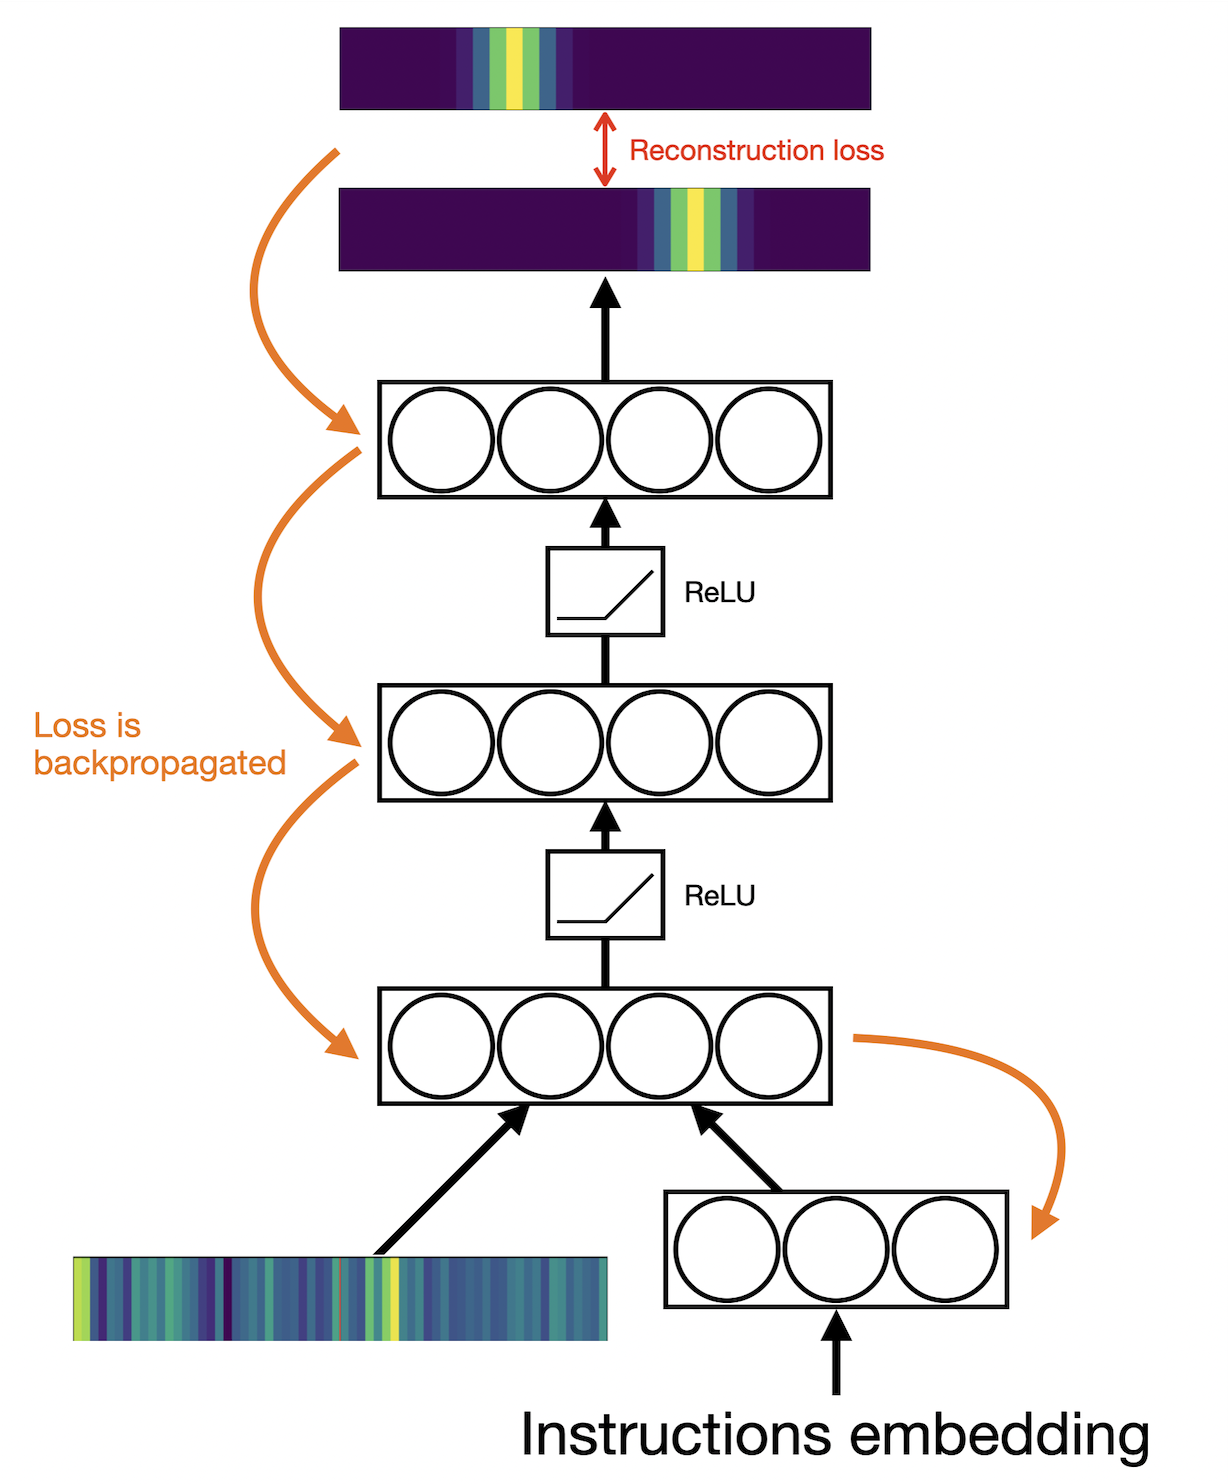

It's a _really_ simple neural network (a [Multi-Layer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron), MLP) with a single hidden layer. It takes as input the concatenated visual stimulus and instruction embedding. The embedding goes through an additional linear layer that reduces its dimensionality from 768 to 256.

In [ ]:
class BaseNet(nn.Module):
  def __init__(self, in_size=STIM_DIM*2, hid_size=256, out_size=STIM_DIM):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_size, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, hid_size),
        nn.ReLU(),
        nn.Linear(hid_size, out_size)
    )

  def forward(self, x):
    return self.layers(x)

class InstructionNet(BaseNet):
  def __init__(self, in_size=STIM_DIM*2, embed_dim=768, lower_embed_dim=64,
               hid_size=256, out_size=STIM_DIM):
    super().__init__(in_size=in_size+lower_embed_dim, hid_size=hid_size,
                     out_size=STIM_DIM)
    self.embedding_weights = nn.Linear(embed_dim, lower_embed_dim)

  def forward(self, x):
    stimulus = x[..., :STIM_DIM*2]
    embed = self.embedding_weights(x[..., STIM_DIM*2:])
    return self.layers(torch.cat((stimulus, embed), dim=-1))

class InstructionNetLarge(BaseNet):
  def __init__(self, in_size=STIM_DIM*2, embed_dim=768,
               hid_size=256, out_size=STIM_DIM):
    super().__init__(in_size=in_size+embed_dim, hid_size=hid_size,
                     out_size=STIM_DIM)

  def forward(self, x):
    return self.layers(x)

class InstructionNetSparse(BaseNet):
  def __init__(self, in_size=STIM_DIM*2, embed_dim=768, lower_embed_dim=64,
               hid_size=256, out_size=STIM_DIM):
    super().__init__(in_size=in_size+lower_embed_dim, hid_size=hid_size,
                     out_size=STIM_DIM)
    self.embedding_weights = nn.Linear(embed_dim, lower_embed_dim)

  def forward(self, x):
    stimulus = x[..., :STIM_DIM*2]
    embed = self.embedding_weights(x[..., STIM_DIM*2:])
    return self.layers(torch.cat((stimulus, embed), dim=-1)), embed

## Boilerplate training code

We define two classes that store most of what we will need for training: a `Logger` which will help us visualize the model training, and a `Trainer` which stores all of the actual training.



In [ ]:
# @title Logger code
class Logger:
    def __init__(self, n_epochs: int, steps_per_epoch: int, update_interval: int = 10):
        """
        Create a logger that maintains two subplots: one for loss-like metrics and one for accuracy-like metrics.
        Metrics are updated by passing a dictionary to the update() method.
        """
        self.n_epochs = n_epochs
        self.steps_per_epoch = steps_per_epoch
        self.total_steps = n_epochs * steps_per_epoch
        self.current_step = 0
        self.update_interval = update_interval

        # Create a notebook-friendly progress bar.
        self.progress_bar = tqdm(total=self.total_steps,
                                 desc="Training Progress", unit="step")

        # Create a figure with two subplots: one for losses, one for accuracies.
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(2, 1, figsize=(14, 8))
        self.ax_loss.set_xlabel("Training Step")
        self.ax_loss.set_ylabel("Loss")
        self.ax_loss.set_title("Loss Metrics Over Time")
        self.ax_acc.set_xlabel("Training Step")
        self.ax_acc.set_ylabel("Accuracy")
        self.ax_acc.set_title("Accuracy Metrics Over Time")

        # These dictionaries will hold the line objects and data for each metric.
        self.lines = {}           # key -> line object
        self.metrics_data = {}    # key -> {"steps": [...], "values": [...]}
        self.metric_colors = {}   # key -> color

        # Obtain colors from the built-in 'tab20c' colormap.
        self.train_colors = plt.get_cmap("tab20c").colors
        self.val_colors = plt.get_cmap("tab20b").colors
        self.train_color_counter = 0
        self.val_color_counter = 0

        # Display the figure once with a fixed display_id.
        display(self.fig, display_id='loss_plot')

    def update(self, epoch: int, step: int, metrics: dict):
        """
        Update the logger with a dictionary of metric values.

        The keys of the dict (e.g. "train_loss", "val_acc") determine:
          - Which subplot the metric is plotted on: keys containing "loss" go to the loss subplot,
            keys containing "acc" (or "accuracy") go to the accuracy subplot.
          - The color: keys containing "train" are assigned a warm color, while "val" keys get a cold color.

        If any key in the dictionary contains "train", the update is assumed to be from a training iteration,
        and the global training step counter is incremented.
        """
        # Determine if this is a training update.
        is_train_update = any("train" in key.lower() for key in metrics)
        if is_train_update:
            self.current_step += 1
            current_step = self.current_step
            self.progress_bar.update(1)
            # Optionally, pick a representative train loss to display in the progress bar.
            train_loss = metrics.get("train_loss", None)
            if train_loss is None:
                # If no "train_loss", search among training metrics that contain "loss".
                for k, v in metrics.items():
                    if "loss" in k.lower() and "train" in k.lower():
                        train_loss = v
                        break
            if train_loss is not None:
                self.progress_bar.set_description(
                    f"Epoch: {epoch+1}/{self.n_epochs} | Step: {step+1}/{self.steps_per_epoch} | Loss: {train_loss:.4f}"
                )
        else:
            current_step = self.current_step
            # For validation-only updates, set a postfix (if a validation loss is provided).
            val_loss = metrics.get("val_loss", None)
            if val_loss is not None:
                self.progress_bar.set_postfix_str(f"Val Loss: {val_loss:.4f}")

        # Loop over each metric provided.
        for key, value in metrics.items():
            key_lower = key.lower()
            # Determine the type of metric based on its key.
            if "loss" in key_lower:
                metric_type = "loss"
                ax = self.ax_loss
            elif "acc" in key_lower or "accuracy" in key_lower:
                metric_type = "acc"
                ax = self.ax_acc
            else:
                # Default to loss if the key doesn't match common patterns.
                metric_type = "loss"
                ax = self.ax_loss

            # Initialize storage for this metric if not present.
            if key not in self.metrics_data:
                self.metrics_data[key] = {"steps": [], "values": []}
            self.metrics_data[key]["steps"].append(current_step)
            self.metrics_data[key]["values"].append(value)

            # Create a line for the metric if it doesn't already exist.
            if key not in self.lines:
                # Determine color based on whether the metric is for training or validation.
                if "train" in key_lower:
                    color = self.train_colors[self.train_color_counter % len(self.train_colors)]
                    self.train_color_counter += 1
                elif "val" in key_lower:
                    color = self.val_colors[self.val_color_counter % len(self.val_colors)]
                    self.val_color_counter += 1
                else:
                    color = "black"  # default fallback
                self.metric_colors[key] = color
                # Create the line on the appropriate axis.
                line, = ax.plot(self.metrics_data[key]["steps"],
                                self.metrics_data[key]["values"],
                                label=key,
                                color=color,
                                linestyle='-')
                self.lines[key] = line
                ax.legend()
            else:
                # If the line exists, update its data.
                line = self.lines[key]
                line.set_data(self.metrics_data[key]["steps"], self.metrics_data[key]["values"])
                ax.relim()
                ax.autoscale_view()

        # Update the figure display periodically.
        if self.current_step % self.update_interval == 0 or self.current_step == self.total_steps:
            display(self.fig, display_id='loss_plot', update=True)

    def close(self):
        self.progress_bar.close()
        display(self.fig, display_id='loss_plot', update=True)
        plt.close(self.fig)

In [ ]:
# @title Trainer code

class MetricsDict(UserDict):
  def __add__(self, other):
    """
    Merge two MetricsDict objects. If a key exists in both,
    the result's value is the sum of the two values.
    Otherwise, the key and its value are carried over as is.
    """
    result = MetricsDict(self.data.copy())
    for key, value in other.items():
      # Use get with a default of 0.0 so that missing keys add as 0.0
      result[key] = result.get(key, 0.0) + value

    return result

  def __repr__(self):
    return f"MetricsDict({self.data})"

class RecSparsityLoss:
  def __init__(self, rec_weight=1., spars_weight=1.):
    self.rec_weight = rec_weight
    self.spars_weight = spars_weight
    self.rec_loss = nn.MSELoss()

  def __call__(self, output, label):
    recloss = self.rec_loss(output[0], label)
    sparsloss = torch.linalg.vector_norm(output[1], ord=1, dim=-1).mean()

    return self.rec_weight * recloss + self.spars_weight * sparsloss



class Trainer:
  def __init__(self,
               lr: float = 1e-4,
               batch_size:int = 128,
               epochs: int = 50,
               criterion = nn.MSELoss(),
               acc_measurer = None,
               accuracy_train = False,
               accuracy_val = True,
               device: str = 'cuda',
               optimizer: Literal['adam'] = 'adam'):
    self.lr = lr
    self.batch_size = batch_size
    self.epochs = epochs
    self.criterion = criterion
    self.acc_measurer = acc_measurer
    self.accuracy_train = accuracy_train
    self.accuracy_val = accuracy_val
    self.device = device
    self.optimizer = optimizer

  @torch.no_grad()
  def _get_task_accs(self, output, label, task, training=True):
    task_acc_dict = MetricsDict()
    all_tasks = list(set(task))
    for t in all_tasks:
      thistask_idx = torch.tensor([i==t for i in task], dtype=torch.bool)
      task_key = f'train_acc_{t}' if training else f'val_acc_{t}'
      task_acc_dict[task_key] = self.acc_measurer(output[thistask_idx],
                                                  label[thistask_idx])
    return task_acc_dict

  def train(self, model, train_dataset, val_dataset=None):
    model = model.to(self.device)
    model.train()

    if self.optimizer == 'adam':
      optimizer = optim.Adam(model.parameters(), lr=self.lr)

    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
    if val_dataset:
      val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

    logger = Logger(n_epochs=self.epochs, steps_per_epoch=len(train_loader))

    for epoch in range(self.epochs):
      for step, (input, label, task) in enumerate(train_loader):
        optimizer.zero_grad()
        input = input.to(self.device)
        label = label.to(self.device)
        output = model(input)
        loss = self.criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        metrics_dict = MetricsDict()
        metrics_dict['train_loss'] = train_loss

        if self.accuracy_train:
          metrics_dict += self._get_task_accs(output, label,
                                              task, training=True)

        logger.update(epoch, step, metrics_dict)

        if val_dataset and step % 25 == 0:
          val_loss = 0.
          metrics_dict = MetricsDict()
          if self.accuracy_val:
            val_labels = []
            val_outputs = []
            val_tasks = []
          with torch.no_grad():
            for input, label, task in val_loader:
              input = input.to(self.device)
              label = label.to(self.device)
              output = model(input)
              val_loss += self.criterion(output, label).item()
              if self.accuracy_val:
                val_labels.append(label)
                val_outputs.append(output[0])
                val_tasks.extend(list(task))
            val_loss /= len(val_loader)
            metrics_dict['train_loss'] = loss.item()
            metrics_dict['val_loss'] = val_loss
            if self.accuracy_val:
              val_outputs = torch.cat(val_outputs, dim=0)
              val_labels = torch.cat(val_labels, dim=0)
              metrics_dict += self._get_task_accs(val_outputs, val_labels,
                                                  val_tasks, training=False)
          logger.update(epoch, step, metrics_dict)

    logger.close()

## Measuring model accuracy

We will need a way to measure the accuracy of the model! Since we have both trials that require a response and trials that require no response, we use the following criteria:

- If the trial requires no response, the model's output should be close to 0 (below a certain threshold).

- If the trial does require a response, the orientation chosen by the model should be within a small window around the target orientation.

In [ ]:
def circular_distance(x, y):
  assert x.shape == y.shape

  pos1 = torch.argmax(x, dim=-1)
  pos2 = torch.argmax(y, dim=-1)

  n = x.shape[-1]

  diff = torch.abs(pos1 - pos2)

  return torch.min(torch.stack([diff, n - diff]), axis=0)[0]

def measure_accuracy(output, label):
  # trials that require no response
  # (response should be close to zero)
  noresp_idx = label.sum(-1)==0
  noresp_correct = (output[noresp_idx].max(-1)[0] < 0.2).float()

  # trials that require a response
  # (response should be within a limit around the correct orientation)
  dist = circular_distance(output[~noresp_idx],
                           label[~noresp_idx])
  resp_correct = (dist < (STIM_DIM/20)).float()

  return torch.mean(torch.cat([noresp_correct, resp_correct])).item()

## Training and held-out tasks

We pick a few tasks for training, and some which will be excluded from the training! Feel free to play around with this 😀

In [ ]:
# Settings for training
tasks = ['DM', 'AntiDM', 'Go', 'OppositeGo', 'CompL', 'CompR', 'DMS', 'DNMS', 'AntiCompL', 'OppositeCompR']
heldout_tasks = ['AntiCompR', 'OppositeCompL']

# Actually train the model!

Finally, we can train the actual model. We first instantiate the model, make sure that the input goes through the transforms we defined earlier, and define separate training and validation datasets.

In [ ]:
model = InstructionNetSparse(in_size=STIM_DIM*2, embed_dim=768, lower_embed_dim=256,
                       hid_size=128, out_size=STIM_DIM)

input_transform = ConcatenateTransforms([
    PopulationVectorTransform(noise=(0.01, 0.2)),
    InstructionEmbedTransform()
])
output_transform = PopulationVectorTransform(label=True)

train_dataset = TaskDataset(tasks=tasks, trials_per_task=3000,
                            input_transform=input_transform, output_transform=output_transform)
val_dataset = TaskDataset(tasks=tasks, trials_per_task=500,
                          input_transform=input_transform, output_transform=output_transform)

In [ ]:
# Actually run the training
trainer = Trainer(lr=0.001, batch_size=64, epochs=20, criterion=RecSparsityLoss(spars_weight=0.01),
                  device='cuda', optimizer='adam', acc_measurer=measure_accuracy)
trainer.train(model=model, train_dataset=train_dataset,
              val_dataset=val_dataset)

## Test the network on different instructions

In [ ]:
test_dataset = TaskDataset(tasks=['Go', 'OppositeGo'], trials_per_task=3000,
                           input_transform=input_transform,
                           output_transform=output_transform,
                           training=False)

In [ ]:
class Tester:
  def __init__(self,
               acc_measurer,
               batch_size = 500,
               device: str = 'cuda'):
    self.acc_measurer = acc_measurer
    self.batch_size = batch_size
    self.device = device

  def test(self, model, test_dataset):
    model = model.to(self.device)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

    with torch.no_grad():
      all_outputs, all_labels, all_tasks = [], [], []
      for input, label, task in test_loader:
        input = input.to(self.device)
        label = label.to(self.device)
        output, _ = model(input)
        all_labels.append(label)
        all_outputs.append(output)
        all_tasks.extend(list(task))
      all_outputs = torch.cat(all_outputs, dim=0)
      all_labels = torch.cat(all_labels, dim=0)
      accuracies_dict = {}
      for t in list(set(all_tasks)):
        thistask_idx = torch.tensor([i==t for i in all_tasks], dtype=torch.bool)
        accuracies_dict[t] = [self.acc_measurer(all_outputs[thistask_idx],
                                               all_labels[thistask_idx])]

    return pd.DataFrame(accuracies_dict)

In [ ]:
tester = Tester(acc_measurer=measure_accuracy)
test_accs = tester.test(model, test_dataset)

In [ ]:
sns.barplot(test_accs)
plt.show()

In [ ]:
# @title Try your own instructions!

orientation_left = 0 # @param {type:"slider", min:0, max:6.28, step:0.01}
orientation_right = 0.0 # @param {type:"slider", min:0, max:6.28, step:0.01}
intensity_left = 1.0 # @param {type:"slider", min:0.80, max:1.20, step:0.01}
intensity_right = 1 # @param {type:"slider", min:0.80, max:1.20, step:0.01}
instructions = 'If the left is more intense than the right pick the left else do nothing' # @param {type: "string"}

def generate_trial(o_l, o_r, i_l, i_r, instructions):
  trial = {'orient_left': [o_l], 'orient_right': [o_r],
          'int_left': [i_l], 'int_right': [i_r],
           'instructions': [instructions]}
  return pd.DataFrame(trial)

input_transform = ConcatenateTransforms([
    PopulationVectorTransform(noise=(0.01, 0.2)),
    InstructionEmbedTransform()
])

model_input = input_transform(generate_trial(orientation_left,
                                             orientation_right,
                                             intensity_left,
                                             intensity_right,
                                             instructions))
draw_gabors(
        orientation=(orientation_left, orientation_right),
        contrast= (intensity_left, intensity_right),
        size=128, frequency=3., sigma=0.3, phase=0.0,
        bg_level=0.5, separation=20, figsize=(6,3)
)
print(instructions)

with torch.no_grad():
  model_output = model(model_input.to('cuda'))[0]

print('Model Output:')
plt.matshow(np.tile(model_output.cpu().numpy(),
                    (3, 1)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

## Test the network on held-out tasks

One of the main results of the paper was the fact that the network could generalize to new tasks - can we replicate this result with out held-out tasks?

In [ ]:
class HeldOutTrainer:
  def __init__(self,
               acc_measurer,
               criterion = nn.MSELoss(),
               lr = 0.001,
               batch_size = 256,
               device='cuda'):
    self.acc_measurer = acc_measurer
    self.criterion = criterion
    self.lr = lr
    self.batch_size = batch_size
    self.device = device

  def train(self, model, tasks_list, input_transform, output_transform):

    task_accuracies = {t: [] for t in tasks_list}
    for task in tasks_list:
      thistask_dataset = TaskDataset(tasks=[task], trials_per_task=5000,
                                     input_transform=input_transform, output_transform=output_transform)
      thistask_loader = DataLoader(thistask_dataset, batch_size=self.batch_size, shuffle=True)
      thistask_model = deepcopy(model)
      optimizer = optim.Adam(thistask_model.parameters(), lr=self.lr)
      for input, label, _ in tqdm(thistask_loader):
        optimizer.zero_grad()
        input = input.to(self.device)
        label = label.to(self.device)
        output = thistask_model(input)
        loss = self.criterion(output, label)
        loss.backward()
        optimizer.step()
        acc = self.acc_measurer(output[0], label)
        task_accuracies[task].append(acc)

    task_accuracies = pd.DataFrame(task_accuracies)
    task_accuracies['average'] = task_accuracies.mean(axis=1)

    return task_accuracies

In [ ]:
test_dataset = TaskDataset(tasks=['Go', 'OppositeGo'], trials_per_task=200,
                          input_transform=input_transform, output_transform=output_transform,
                           training=False)

In [ ]:
heldout_tasks

In [ ]:
heldout_trainer = HeldOutTrainer(acc_measurer=measure_accuracy, criterion=RecSparsityLoss())
instruct_accs = heldout_trainer.train(model, heldout_tasks, input_transform, output_transform)

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(instruct_accs, ax=ax)
ax.set_ylim(0, 1)
plt.show()

# Visualize Task Representations

We use a library called `torchlens` to extract representations from the last hidden layer of the network, as well as the lower-dimensional instruction embedding. We use PCA to reduce the activations' dimensionality to 3D, to actually visualize them.

In [ ]:
!pip install torchlens

In [ ]:
import torchlens as tl

In [ ]:
def extract_hidden_activation(model, input, layers, device='cuda'):
  model = model.to(device)
  input = input.to(device)
  model.eval()
  with torch.no_grad():
    model_history = tl.log_forward_pass(model, input)
  activ_dict = {}
  for l in layers:
    activ_dict[l] = model_history[l].tensor_contents
  return activ_dict

## Create a dataset to visualize different task representations

In [ ]:
visualize_tasks = ['Go', 'OppositeGo']

In [ ]:
vizdataset = TaskDataset(tasks=visualize_tasks, trials_per_task=100,
                         input_transform=input_transform, output_transform=output_transform)

In [ ]:
activations = extract_hidden_activation(model, vizdataset[:][0],
                                        layers=['linear_1_3', 'linear_3_7'])
task_embeds_activs = activations['linear_1_3'].cpu().numpy()
hidden_layer_activs = activations['linear_3_7'].cpu().numpy()
task_embeds_activs_3d = PCA(n_components=3).fit_transform(task_embeds_activs)
hidden_layer_activs_3d = PCA(n_components=3).fit_transform(hidden_layer_activs)

In [ ]:
# @title Visualize task embedding representations

viz_tasks = np.array(vizdataset.trial_df['task'].tolist())
unique_tasks = np.unique(viz_tasks)
colors = plt.get_cmap("tab10")

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for i, task in enumerate(unique_tasks):
    idx = viz_tasks == task
    ax.scatter(task_embeds_activs_3d[idx, 0],
               task_embeds_activs_3d[idx, 1],
               task_embeds_activs_3d[idx, 2],
               color=colors(i),
               label=str(task))
ax.legend()
plt.show()

In [ ]:
# @title Visualize hidden layer representations

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

for i, task in enumerate(unique_tasks):
    idx = viz_tasks == task
    ax.scatter(hidden_layer_activs_3d[idx, 0],
               hidden_layer_activs_3d[idx, 1],
               hidden_layer_activs_3d[idx, 2],
               color=colors(i),
               label=str(task))
ax.legend()
plt.show()

# Exercise: train a baseline model

There is one crucial component we are missing to make our study properly "scientific" - a baseline model.
Before looking at the code, can you think of what this might be?

In [ ]:
# @title Baseline model code

class SimpleNetSparse(BaseNet):
  def __init__(self, in_size=STIM_DIM, task_dim=128, task_embed_dim=64,
                hid_size=256, out_size=STIM_DIM):
    super().__init__(in_size=in_size+task_embed_dim, hid_size=hid_size,
                      out_size=STIM_DIM)
    self.embedding_weights = nn.Linear(task_dim, task_embed_dim)

  def forward(self, x):
    stimulus = x[..., :STIM_DIM*2]
    embed = self.embedding_weights(x[..., STIM_DIM*2:])

    return self.layers(torch.cat((stimulus, embed), dim=-1)), embed

class TaskOrthoTransform:
  def __init__(self, tasks_list, dim=64, seed=123, to_tensor=True):
    self.tasks_list = tasks_list
    self.dim = dim
    self.m = ortho_group(dim=dim, seed=seed).rvs()
    self.to_tensor = to_tensor

  def __call__(self, trial_params):
    task_idx = [self.tasks_list.index(t) for t in trial_params['task'].tolist()]
    task_vectors = self.m[task_idx]
    if self.to_tensor:
      task_vectors = torch.tensor(task_vectors, dtype=torch.float)
    return task_vectors